# Le Teil earthquake epicenter location likelihood

<img src="images/logo-epos.png" style="margin:10px; height:80px;"/><img src="images/logo-esa.png" style="margin:10px; height:100px;"/><img src="images/logo-ipgp-upc.png" style="margin:10px; height:80px;"/>

The original version of this notebook was made by Antoine Lucas and Gregory Sainton. The current notebook was edited in 2023 by Leonard Seydoux (seydoux@ipgp.fr) to be used in the course _Earth Data Science_ at the [Institut de Physique du Globe de Paris](https://www.ipgp.fr/fr) (IPGP). If you have found a bug or have a suggestion, please feel free to contact me.

## 1. Introduction

On November 11, 2019, a Mw 4.9 earthquake occured in the south of France, near the city of Le Teil. In this notebook, we will use the seismic data recorded by the RESIF network to estimate the epicenter location by a simple Monte Carlo method.

This notebook is based on the example of _estimation of an epicenter: direct use of the probabilistic method_ made by Albert Tarantola, from the book _Inverse Problem Theory and Methods for Model Parameter Estimation_ (SIAM, 2005), pp. 253-256. We will use seven stations from the [French part of the European Plate Observing System (EPOS)](https://www.epos-france.fr/) and explore some parameters of the problem. We will also use the InSAR data from the Sentinel-1 satellite a a prior information to constrain the epicenter location. The production of the InSAR displacement map (available in the `data` repository) was made by Antoine Lucas using SNAP.

In [1]:
import os 

import matplotlib.pyplot as plt
import numpy as np
import obspy
from obspy.clients.fdsn import Client

import solver

## 1. Introduction

### 1.1. Inverse problem theory

Introducing to the topic of probabilistic methods, Albert Tarantola wrote in his book [Inverse Problem Theory](https://www.ipgp.fr/~tarantola/Files/Professional/Books/InverseProblemTheory.pdf), edited by Siam in 2005 (slightly modifified from p.20).

Experiments suggest physical theories, and physical theories predict the outcome of experiments. The comparision of the predicted outcome with the observed outcome allows us to improve the theory. If in the _physical theory_ we include the physical parameters describing the system under study, then inverse problem theory is about the quantitative rules to be used for this comparison between predictions and observations.

To solve a _forward problem_ means to predict the error-free values of the observables $\mathbf{d} = (d_1, d_2, \ldots)$ that would correspond to a given model $\mathbf{m} = (m_1, m_2, \dots)$. It can be formally written in the form

$$\mathbf{m} \mapsto \mathbf{d} = \mathbf{g}(\mathbf{m}),$$

where $\mathbf{d} = \mathbf{g}(\mathbf{m})$ is a short notation for the set of equations $d_i = g_i(\mathbf{m})$, and $\mathbf{g}$ is the _forward operator_ that contains the mathematical model of the physical system under study. It is usually a nonlinear operator, and it is often ill-posed. 

### 1.2. Earthquake epicenter location problem

In the problem of earthaquake epicenter likelihood estimation, the model parameters $\bf m$ are the coordinates (the latitude $\lambda$ and longitude $\varphi$) of the epicenter, simplified here in two dimensions:

$$\mathbf{m} = (\lambda, \varphi) \in \mathbb{R}^2.$$

The data parameters $\bf d$ can be the arrival times of the seismic waves at the $N$ seismic stations that can be written as

$$\mathbf{d} = (t_1, \ldots, t_N) \in \mathbb{R}^N.$$

Note that the arrival times can be noisy due to several reasons (the noise in the data, picking accuracy). If the speed of the seismic waves in the medium between the source and the sensors is known, it is possible to predict, thanks to a given physical model, the arrival times of the seismic waves $\hat{\mathbf{d}}$ at the stations for a given epicenter location. In other terms, we can then apply the forward problem

$$\hat{\mathbf{d}} = \mathbf{g}(\mathbf{m}).$$

In the present case, the forward operators $g_i$ is the travel time model that predicts the travel times $t_i$ for a given epicenter location $m$ at the seismic sensor located at position $(\lambda_i, \varphi_i)$, and it is based on the knowledge of the velocity model of the medium. In this notebook, we will use a simple velocity model that does not depend on space, that is, the forward operator is linear and only depends on the distance between the epicenter and the station. 

> __Question 1.__ Give the form of the forward operator $g_i$ for a linear velocity model, noting $v$ the space-independent velocity of the _P_ wave in the medium. What are the assumptions made in this model?
> 
> __Answer 1.__ The coordinates of the seismic stations and the velocity of the _P_ wave are assumed which means that the velocities uncertainties are supposed to be negligible in comparison with the uncertainties of the observed arrival times. For a source located at the position $\mathbf{m} = (\lambda, \varphi)$, the predicted arrival times $\hat{t}_i$ of the seismic wave recorded at station $i$ located at $(\lambda_i, \varphi_i)$ are predicted by the forward model $g_i$ as
> 
> $$ \hat{t}_i = g_i(\lambda, \varphi) = \frac{1}{v}\delta(\lambda, \varphi, \lambda_i, \varphi_i),$$
>
> where $\delta$ is the great-circle distance between the source and the station.

### 1.3. Probabilistic inversion

From the lecture, we know that the _posterior_ information $\sigma(\mathbf{m})$ is a combination of all informations we have which can be expressed as 

$$\sigma(\mathbf{m}) = k \rho(\mathbf{m}) L(\mathbf{m})$$

where $k$ is a normalization constant, $\rho(\mathbf{m})$ is the _a priori_ in the model space, and $L(\mathbf{m})$ is the likelihood function which gives a measure of the agreement between the observed data and the predicted data, in other terms, on how good the model $\mathbf{m}$ fits the data $\mathbf{d}$. If we consider the uncertainties to be Gaussian with a standard deviation $\nu$, the likelihood function $L(\mathbf{m})$ is expressed as:

$$L(\mathbf{m}) = k' \exp\left( -\frac{1}{2} \sum\limits_{i=1}^{n} \left(\frac{t_{i}-g_i(\mathbf{m})}{\nu}\right)^2 \right)$$

where $k'$ is a normalization constant. Injecting the likelihood function into the posterior information, we obtain

$$
\sigma(\mathbf{m}) = kk' \rho(\mathbf{m}) \exp\left( -\frac{1}{2} \sum_{i=1}^{n} \left(\frac{t_{i}-g_i(\mathbf{m})}{\nu}\right)^2\right)
$$

For now, we can take the a priori information $\rho(\mathbf{m})$ as a constant, since we do not have yet a priori information about the epicenter location. We will come back to this point later. The posterior information $\sigma(\mathbf{m})$ is then proportional to the likelihood function $L(\mathbf{m})$, which means that the maximum of the posterior information is also the maximum of the likelihood function. We can then maximize the likelihood function to find the epicenter location, denoted $m^*$, that best fits the data. The maximum of the likelihood function is obtained by maximizing the following function:

$$
\mathbf{m}^* = (\lambda^*, \varphi^*) = \arg\max\limits_{\mathbf{m}}\, \exp\left(-\frac{1}{2} \sum\limits_{i=1}^{n} \left(\frac{t_{i}-g_i(\mathbf{m})}{\nu}\right)^2\right).
$$

> __Question 2.__ What is the difference between the maximum of the posterior information and the maximum of the likelihood function? How would the expression of the posterior information change if we had a priori information about the epicenter location?
> 
> __Answer 2.__ The maximum of the posterior information is the maximum of the likelihood function multiplied by the a priori information. If we had a priori information about the epicenter location, we would have to multiply the likelihood function by the a priori information, which would change the expression of the posterior information.

## 2. Reading and preparing the data

### 2.1. Get event information from EPOS-France

Of course when inferring an earthquake epicenter, you often have a bare idea of the event's location and time (human reports, timing of the first arrivals, etc.). Here we use the exact information provided by the BRGM (Bureau de Recherches Géologiques et Minières) that is available on the [website of EPOS-France](https://www.epos-france.fr/blog/2021/01/19/reponse-rapide-de-la-communaute-resif-au-tremblement-de-terre-mw-4-9-du-11-novembre-2019-au-teil/). We will then fetch the event information from the EPOS-France web service using the `obspy` package. 

Note that the data from EPOS-France is still available via the `RESIF` entry within `obspy`, as it was renamed to EPOS-France in 2022. 

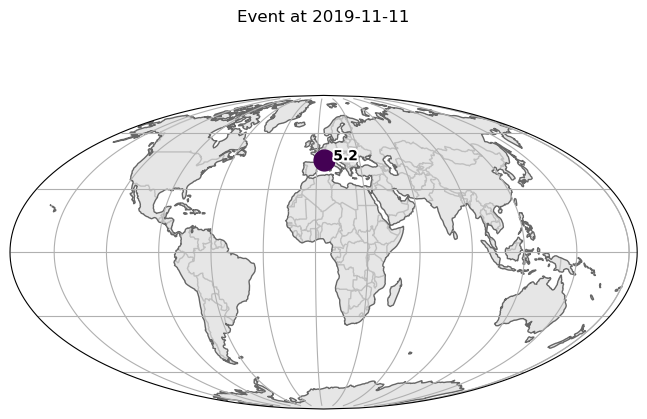

In [2]:
# Connect to the RESIF web service
client = Client("RESIF")

# Get a list of events around the time of the earthquake
catalog = client.get_events(
    starttime=obspy.UTCDateTime(2019, 11, 11, 10, 50),
    endtime=obspy.UTCDateTime(2019, 11, 11, 10, 55),
)

# Plot the events on a map
catalog.plot()
plt.show()

### 2.2 Fetch available stations

We can now look for available seismic station around the time and place of the estimated earthaquake location. Note that with the seismic network in France, we have a good coverage of the country and may find already about 10 seismic station with a distance of less than 100km from the epicenter. We will use the `obspy` package to fetch the available stations.

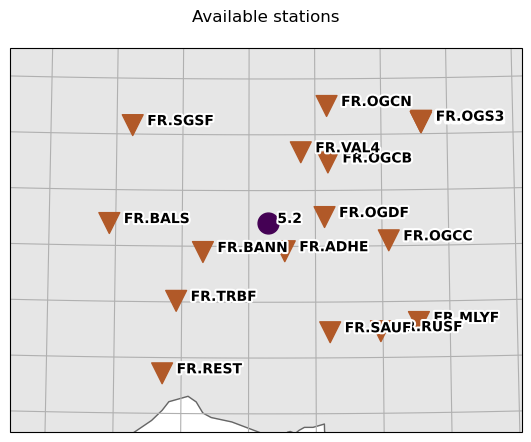

In [3]:
# Get the only event in the catalog
event = catalog[0]

# Look for station near the epicenter
inventory = client.get_stations(
    network="FR",
    channel="HHZ",
    starttime=event.origins[0].time - 5,
    endtime=event.origins[0].time + 125,
    latitude=event.origins[0].latitude,
    longitude=event.origins[0].longitude,
    maxradius=1,
    matchtimeseries=True,
)

# Plot inventory
fig = inventory.plot(projection="local", resolution="i", show=False)
catalog.plot(projection="local", resolution="i", fig=fig, title="Available stations")
plt.show()

### 2.3. Download waveforms

We can now download the seismic waveforms from the seismic stations we have found in the previous step. We will use the `obspy` package to fetch the seismic records. We will work at the natural sampling rate of the stations, which is 100Hz for most of them. We will also use the `obspy` package to plot the seismic records.

In [4]:
# Create an empty stream object
stream = obspy.Stream()

# Loop every network and station
for network in inventory:
    for station in network:

        try:

            # Get waveform data
            trace = client.get_waveforms(
                network.code,
                station.code,
                "*",
                "HHZ",
                starttime=event.origins[0].time - 5,
                endtime=event.origins[0].time + 125,
            )

            # Merge data
            trace.merge(fill_value="interpolate")

            # Keep only one trace if several returned
            trace = trace[0]

            # Add station location
            trace.stats.coordinates = {
                "latitude": station.latitude,
                "longitude": station.longitude,
            }

            # Add to stream
            stream += trace

        except:

            # If no data, print a message and continue
            print(f"No data found for station {network.code}.{station.code}")

# Save stream as pickle file to keep the coordinates (not possible with miniseed)
stream.write("data/waveforms.pickle", format="PICKLE")

# Print success message
print(f"Saved {len(stream)} traces in ./data/waveforms.pickle")

No data found for station FR.ADHE
No data found for station FR.OGS1
No data found for station FR.REST
No data found for station FR.SGSF
No data found for station FR.TRBF
No data found for station FR.VAL4
Saved 11 traces in ./data/waveforms.pickle


> __Question 3.__ Plot the various seismic waveforms and give a basic description of what you observe. using the `plot` method of a `Stream` object, plot them as a function of the epicentral distance to the earthquake. What is the sampling rate of the seismic records? What is the unit of the waveform amplitudes? Check the documentation of the `obspy` package to find the answer if needed. 
>
> __Answer 3.__ We check the properties of the seismic records using the `stats` attribute of the `Trace` object, obtained from the elements of the `Stream` object. See the ouput of the cell below. The amplitude of the waveforms is in counts.

               network: FR
               station: BALS
              location: 00
               channel: HHZ
             starttime: 2019-11-11T10:52:40.850000Z
               endtime: 2019-11-11T10:54:50.840000Z
         sampling_rate: 100.0
                 delta: 0.01
                  npts: 13000
                 calib: 1.0
_fdsnws_dataselect_url: http://ws.resif.fr/fdsnws/dataselect/1/query
               _format: PICKLE
           coordinates: AttribDict({'latitude': 44.519686, 'longitude': 3.451818})
              distance: 0.8482911175996147
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 7, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 4096, 'filesize': 28672})
            processing: ['ObsPy 1.4.0: trim(endtime=UTCDateTime(2019, 11, 11, 10, 54, 50, 840000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2019, 11, 11, 10, 52, 40, 840000))']
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 200.0, 200.0, 100.0, 1

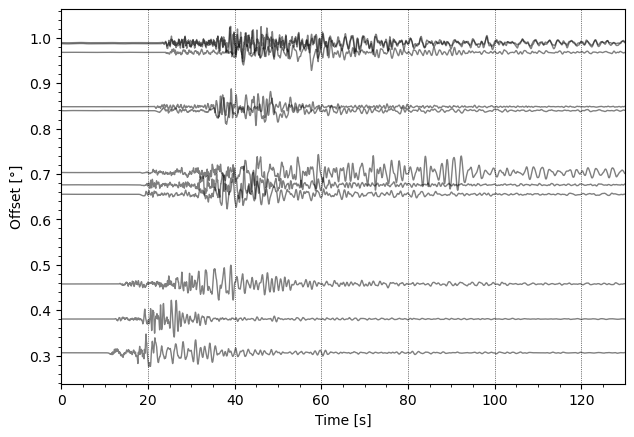

In [16]:
# Load stream from pickle file
stream = obspy.read("data/waveforms.pickle")

# Calculate the distance between the event and each station
for trace in stream:
    trace.stats.distance = obspy.geodetics.locations2degrees(
        event.origins[0].latitude,
        event.origins[0].longitude,
        trace.stats.coordinates["latitude"],
        trace.stats.coordinates["longitude"],
    )

# Prepare figure
fig = plt.figure()

# Plot the stream
stream.plot(
    type="section",
    orientation="horizontal",
    dist_degree=True,
    ev_coord=(event.origins[0].latitude, event.origins[0].longitude),
    show=False, 
    fig=fig,
)

# Print example trace
print(stream[0].stats)

# Sampling frequency
print([trace.stats.sampling_rate for trace in stream])


### 2.4. Plot the waveforms and pick the P-wave arrival times

Now we can explore the data content and pick the P-wave arrival times. Picking seismic arrival times is a difficult task that requires a lot of experience. Usually, this is done by a human expert. Here we will use the `obspy` package to pick the P-wave arrival times, using a old-school method based on the STA/LTA ratio (short-time average over long-term average). We will use the `obspy` package to plot the seismic records and the picked arrival times.

> __Question 3.__ The STA/LTA method is a simple method to pick the P-wave arrival times. What are the advantages and disadvantages of this method? What values of the STA/LTA ratio would you use to pick the P-wave arrival times?
> 
> __Answer 3.__ The STA/LTA method is a simple method to pick the P-wave arrival times. It is based on the fact that the P-wave arrival times are characterized by a high-frequency content, which is not the case for the noise. The STA/LTA method is based on the ratio of the short-term average (STA) and the long-term average (LTA) of the seismic records. The STA/LTA ratio is high for the P-wave arrival times and low for the noise. The STA/LTA method is simple to implement and can be automated. However, it is not robust to the presence of high-frequency noise in the seismic records. We will use a STA of 3 and a LTA of 8 to pick the P-wave arrival times, after some trial and error. We note that this value is not optimal for all the stations (such as OSG2).

No onset found for FR.OGS2.00.HHZ


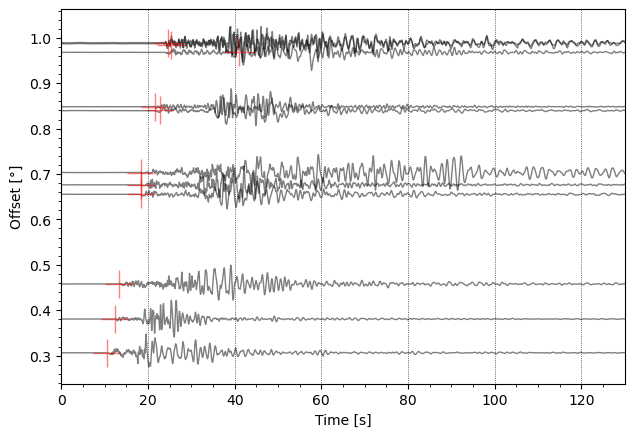

In [58]:
from obspy.signal.trigger import classic_sta_lta, trigger_onset

# Define the short and long term average
short_term_average = 3
long_term_average = 8

# Get firt arrive time
for trace in stream:
    # Convert short and long term average to number of samples
    n_sta = int(short_term_average * trace.stats.sampling_rate)
    n_lta = int(long_term_average * trace.stats.sampling_rate)

    # Get trigger
    trigger = classic_sta_lta(trace.data, n_sta, n_lta)

    # Get onset from trigger function
    onset = trigger_onset(trigger, 2, 0.5)

    # If onset is found, add it to the trace
    if np.size(onset) > 0:
        onset = onset[0, 0]
        trace.stats.onset = onset / trace.stats.sampling_rate
    else:
        # Print a message if no onset is found
        print(f"No onset found for {trace.id}")

# Prepare figure
fig = plt.figure()

# Plot the stream
stream.plot(
    type="section",
    orientation="horizontal",
    dist_degree=True,
    ev_coord=(event.origins[0].latitude, event.origins[0].longitude),
    show=False, 
    fig=fig,
)

# Plot the onset
for trace in stream:
    plt.plot(trace.stats.onset, trace.stats.distance, "r+", mfc="none", ms=20, alpha=0.5)

## 3. Inversion

### 3.1. Epicenter likelihood from a few stations

At first we will work with (deliberately) too few seismic stations which naturally brings biases in the estimation of the epicenter location. We will select three stations located in a line along the Rhône valley: OGCN, OGCB, and OGDF. The cell below allows you to select the traces from these three stations.

In [115]:
# Extract selected traces
stream_line = obspy.Stream()
for station in ("OGCN", "OGCB", "OGDF"):
    stream_line += stream.select(station=station)
    
# Print stream information
print(stream_line)

3 Trace(s) in Stream:
FR.OGCN.00.HHZ | 2019-11-11T10:52:40.850000Z - 2019-11-11T10:54:50.840000Z | 100.0 Hz, 13000 samples
FR.OGCB.00.HHZ | 2019-11-11T10:52:40.850000Z - 2019-11-11T10:54:50.840000Z | 100.0 Hz, 13000 samples
FR.OGDF.00.HHZ | 2019-11-11T10:52:40.850000Z - 2019-11-11T10:54:50.840000Z | 100.0 Hz, 13000 samples


### 3.2. Likelihood computation

Now the idea is to sample the probability density $L(\mathbf{m})$ at random potential positions $\{\mathbf{m}_i\}_{i=1\dots K}$ to have an idea of the entire probability distribution.

> __Question 4.__ Using the method `solver.random_coordinates`, write a method that allows to evaluate the model likelihood as a function of the tested epicenter location. 
>
> __Answer 4.__ See the function coded in the `solver` module under the name `monte_carlo_gaussian`.

In [117]:
# Define the extent of the model
extent = [3, 7, 43, 46]

# Run the Monte Carlo simulation
latitudes, longitudes, likelihood = solver.monte_carlo_gaussian(
    stream_line, shots=10000, uncertainty=10, wavespeed=4, extent=extent
)

### 3.3. Plot the likelihood

We can now plot the likelihood function as a function of the epicenter location. Using the `scatter` method of the `matplotlib.pyplot` package, we can color the points according to the value of the likelihood function. We can also plot the epicenter location that maximizes the likelihood function.

> __Question 5.__ Plot the likelihood function as a function of the epicenter location. What is the epicenter location that maximizes the likelihood function? Note that we only calculate the a function that is proportional to the likelihood function, and not the likelihood function itself. How should we name the colorbar label in the plot?
> 
> __Answer 5.__ The epicenter location that maximizes the likelihood function is $(\lambda^*, \varphi^*) = (44.62, 4.52)$. We should name the colorbar label as "proportional to the likelihood".

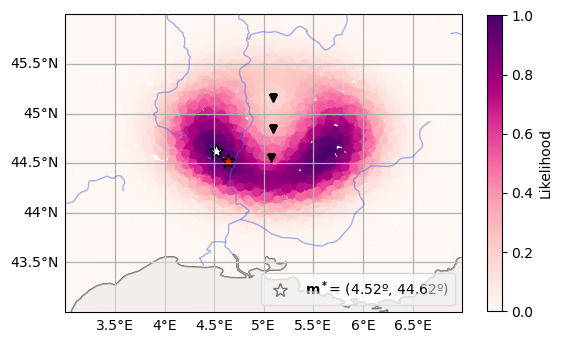

In [144]:
# Plot the likelihood
ax = solver.basemap(extent=extent, stream=stream_line, event=event)

# Plot likelihood
img = ax.scatter(longitudes, latitudes, c=likelihood, cmap="RdPu", s=30)
plt.colorbar(img, ax=ax, label="Likelihood", shrink=0.8)

# Plot the epicenter
index_max = np.argmax(likelihood)
label = rf"$\bf m^*$= ({longitudes[index_max]:.2f}º, {latitudes[index_max]:.2f}º)"
plt.plot(longitudes[index_max], latitudes[index_max], "k*", label=label, mfc="w", ms=10)
ax.legend()

# Show
plt.show()

### 3.4. Working with all the stations

Now we will work with all the stations we have found in the previous step. 

> __Question 6.__ Using the same method than in the previous case, recalculate the likelihood function and plot it as a function of the epicenter location using all the available stations. What difference do you see with the previous case? What is the epicenter location that maximizes the likelihood function? What value of the wavespeed seems to be the best fit for the data?
> 
> __Answer 6.__ The epicenter location that maximizes the likelihood function is $(\lambda^*, \varphi^*) = (44.62, 4.66)$. The difference with the previous case is that the likelihood function is more peaked around the maximum, and closer to the ground truth. The value of the wavespeed that seems to be the best fit for the data is $v = 3.5$ km/s. We note that in the previous case, we also observe that there is a strong uncertainty in the location because of the symmetry of the likelihood function that is due to the linear shape of the seismic stations.

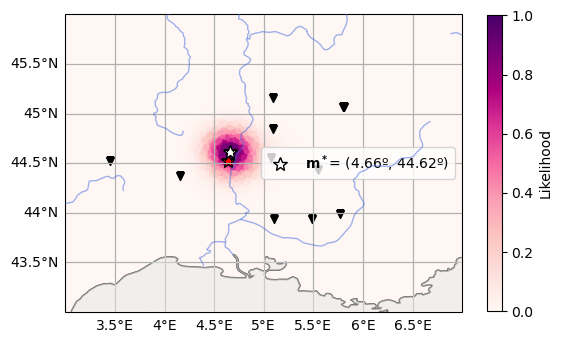

In [145]:
extent = [3, 7, 43, 46]

latitudes, longitudes, likelihood = solver.monte_carlo_gaussian(
    stream, shots=40000, uncertainty=10, wavespeed=3.5, extent=extent
)

# Plot the likelihood
ax = solver.basemap(extent=extent, stream=stream, event=event)

# Plot likelihood
img = ax.scatter(longitudes, latitudes, c=likelihood, cmap="RdPu", s=9)
plt.colorbar(img, ax=ax, label="Likelihood", shrink=0.8)

# Plot the epicenter
index_max = np.argmax(likelihood)
label = rf"$\bf m^*$= ({longitudes[index_max]:.2f}º, {latitudes[index_max]:.2f}º)"
plt.plot(longitudes[index_max], latitudes[index_max], "k*", label=label, mfc="w", ms=10)
ax.legend()

# Show
plt.show()

As we can see on these plots, the time picking for OGCC is erroneous. Actually, this means that the problem is statistically biaised. In fact, we introduced an aberrant arriving time ```Tobs```  at  one station.  Because the Gaussian assumption is used, the result is very sensitive to big errors (even if there is a small number of them).

### 3.4. Deal with biases in dataset

Your are invited to consider changing the Gaussian model by the more robust Laplacian model,
and/or introducing a priori information.  

First, here is the Laplace distribution:

$\begin{equation}
L_L(m) = k.exp{\left[-\sum\limits_{i=1}^{n} \frac{\lvert t_{i}-t_{obs}\lvert}{\sigma_i}\right]} \tag{6}
\end{equation}$

where $k$ is a normalization constant. For sake of simplicity of this lab, we can ignore it. 

#### Questions

1. Modify the function ```MC_Gauss(...)``` to ```MC_Laplace(...)``` to use the Laplacian distribution.
2. Make your function run over the parameters space and plot the results
3. Which station is concerned by the biais?

In [ ]:
extent = [3, 7, 43, 46]

latitudes, longitudes, likelihood = solver.monte_carlo_laplacian(
    stream, shots=40000, uncertainty=6, wavespeed=4, extent=extent
)

# Plot the likelihood
ax = solver.basemap(extent=extent, stream=stream, event=event)

# Plot likelihood
img = ax.scatter(longitudes, latitudes, c=likelihood, cmap="RdPu", s=9)
plt.colorbar(img, ax=ax, label="Likelihood", shrink=0.8)

# Show
plt.show()

#### Comments
Accounting for a more robust model, the inversion is somewhat less biaised and the result is better. 

### 3.5. Introducing a priori information from InSAR

Now, we will add a priori information from surface displacement obtained from Sentinel-S1 InSAR between the Nov. 6 and Nov. 12. First, we need to read the displacement map. The results are contained in a GeoTiff file ``InSAR_S1/Drome_EQTeil_displacement_VV_06Nov2019_12Nov2019.tif``. This file comes with Geo Tags in Exifs. For reading these metadata various libs exist, such as ``rasterio``, ``georaster``, ``osgeo``. ``PIL`` and ``OpenCV`` are other image processing libraries that could be also considered. Because you may not have these libs installed, we made a copy into a PNG flat file that can be directly read with ``matplotlib`` or ``scipy`` that should be present in your system. Unfortunately, the Geo tags are no more present into the file and the image footprint in Lamber 93 system needs to be manually provided as:

```python
ul=[825930.7,6376723.7]
lr=[840754.7,6387758.4]
```

Note that we do a simplistic remapping of the geographic coordinates which is sufficient for the purpose of the lab but a proper warping should be done for accurate results. For those interested in exploring the geospatial approach   the mandatory libs need to be installed. You would need the ``Scripts/ConvertProj.ipynb`` for converting the geographic coordinates into Lambert-93.

In [ ]:
ul=[825930.7,6376723.7]
lr=[840754.7,6387758.4]

**Hint**

The ``.imread`` function of ``matplotlib`` returns a ``numpy.array``

In [ ]:
im = plt.imread('data/Drome_EQTeil_displacement_VV_06Nov2019_12Nov2019.png')

In [ ]:
fig, ax = plt.subplots()
ax.imshow(im,interpolation='bilinear', cmap=cm.RdYlGn,
               extent=[ul[0], lr[0],ul[1], lr[1]])
plt.title('InSAR from Sentinel-1 (Master: 6-Nov / Slave: 12-Nov)')
ax.set_aspect('equal', 'box')

Let's use this location as a prior on the inversion. We take the center of the displaced area in X coordinate (named ``xx``) and we take an uncertainties sigma of  the lateral extend (i.e., ``sigma2``). Then we compute a prior with a Gaussian distribution, centered in ``xx`` with a standard deviation ``sigma2``. We test with ```MC_Gauss(...)``` function and the ``problem2`` defined above : 
```python
xx=832000;
sigma2=2000;
```

In [ ]:
xx=832000; 
sigma2=2000;
#yy=6382000

gobs_InSar = MC_Gauss(problem1, param_space)


fprior =    np.exp( -0.5* (gobs_InSar[:,0] - xx)**2/sigma2**2)

gobs_InSar[:,2] = fprior*gobs_InSar[:,2];
title = 'EQ estimation from 3 stations, with Prior'
plot_dist_obs(gobs_InSar, problem1, title)

#### Comments

Providing an a priori when the observable are biased (i.e., problem1) is strongly helpfull.

Now, let's play with problem2:

In [ ]:
gobs_InSar2 = MC_Laplace(problem2, param_space)
fprior =    np.exp( -0.5* (gobs_InSar2[:,0] - xx)**2/sigma2**2)
gobs_InSar2[:,2] = fprior*gobs_InSar2[:,2];
title = 'EQ estimation from 7 stations, with Prior and error'
plot_dist_obs(gobs_InSar2, problem2, title)

The solution is helped by the a priori knowledge of the problem. 

### 3.6 Further investigations 
First, let evaluate our solution with the actual one.

In [ ]:
# Here we search for the maximum probability, but keep in mind that the less probable solution are still valid.

ind = np.where(gobs_InSar2[:,2]==np.max(gobs_InSar2[:,2]))
Xprob = gobs_InSar2[ind,0] ; Yprob = gobs_InSar2[ind,1]

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(gobs_InSar2[:,0]/1000., gobs_InSar2[:,1]/1000., edgecolors='none', 
               s=10, c=gobs_InSar2[:,2], cmap=plt.cm.OrRd)          
ax.scatter(problem2["longitude"]/1000., problem2["latitude"]/1000.,
               edgecolors='k',s=20)
ax.scatter(Xprob/1000,Yprob/1000,edgecolors='k',s=40)

# Actual location from references:
XEQ=832796
YEQ=6381286
ax.scatter(XEQ/1000,YEQ/1000, edgecolors='k',s=40)

ax.set(xlabel='X-Lon. [km]', ylabel='Y-Lat. [km]', 
           title=title)
ax.set_aspect('equal', 'box')
for i, point in problem2.iterrows():
        ax.text(point['longitude']/1000.+2, point['latitude']/1000., str(point['station']))
         
plt.show()

We see that our most probable solution is closed to the actual's. In any case, the actual solution is inside our most probable area. So even with our simplifications and biais for one station, our solution is acceptable.

Now, let's retrieve the correct time arrival at ``OGCC`` from our most probable location.

In [ ]:
Xstep=problem2[problem2["station"].isin(["OGCC"])]["longitude"].to_numpy()
Ystep=problem2[problem2["station"].isin(["OGCC"])]["latitude"].to_numpy()
Tcal = np.sqrt((Xprob - Xstep)**2 + (Yprob - Ystep)**2)/param_space["v"]
problem_corr = problem2.copy()
problem_corr.head()

In [ ]:
problem_corr.loc[problem_corr["station"].isin(["OGCC"]), 'Tobs'] = Tcal
data_picking.loc[data_picking["station"].isin(["OGCC"]), 'Tobs'] = Tcal

problem_corr.head()

In [ ]:
plot_trace(problem_corr)

Let's play with some parameter of the model, for example, let's try v = 5041;

In [ ]:
param_space = {}

param_space["Xmin"] = 7.8e5 
param_space["Xmax"] = 9.5e5;
param_space["Ymin"] = 6.3e6; 
param_space["Ymax"] = 6.46e6;
param_space["n_run"]= 5e5;  
param_space["v"]    = 5041; 

sol_corr = MC_Laplace(problem_corr, param_space)

ind = np.where(sol_corr[:,2]==np.max(sol_corr[:,2]))
Xprob = sol_corr[ind,0] ; Yprob = sol_corr[ind,1]


title='Solution with correction and v=5km/s'
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(sol_corr[:,0]/1000., sol_corr[:,1]/1000., edgecolors='none', 
               s=10, c=sol_corr[:,2], cmap=plt.cm.OrRd)          
ax.scatter(problem_corr["longitude"]/1000., problem_corr["latitude"]/1000.,
               edgecolors='k',s=20)
ax.scatter(Xprob/1000,Yprob/1000,edgecolors='k',s=40)

# Actual location from references:
XEQ=832796
YEQ=6381286
ax.scatter(XEQ/1000,YEQ/1000, edgecolors='k',s=40)

ax.set(xlabel='X-Lon. [km]', ylabel='Y-Lat. [km]', 
           title=title)
ax.set_aspect('equal', 'box')
for i, point in problem_corr.iterrows():
        ax.text(point['longitude']/1000.+2, point['latitude']/1000., str(point['station']))
         
plt.show()

Our solution becomes really close the real one.

## Some references

CNRS report (in French):
https://www.cnrs.fr/fr/seisme-du-teil-vers-une-reevaluation-du-risque-sismique-en-france-et-en-europe-de-louest

Journal article (in English): https://doi.org/10.1038/s43247-020-0012-z